# Load Images

## Compare hrHSI and Snapshot

### Load HrHSI

In [ ]:
from preprocessing import preprocessHrHSI

# Specify paths
hr_path = "data/FX10/corn_m3"
hr_mtx_path = 'calibration/hrHSI_matrix.npy'
hr_dist_path = 'calibration/hrHSI_dist.npy'

# Load and preprocess file
hr_file = preprocessHrHSI(hr_path + ".hdf5", hr_mtx_path, hr_dist_path)
hr_img = hr_file[0]
hr_wavelengths = hr_file[1]

In [ ]:
# Preview hrHSI
from preprocessing import previewHrHSI
previewHrHSI(hr_img, hr_wavelengths, 
             selected_pixel=(500, 500),
             selected_spectrum=200)

### Load Snapshot

In [ ]:
from preprocessing import preprocessSnapshot

# Specify paths
ss_path = "data/Snapshot/processed/train/corn_m3/"
ss_mtx_path = 'calibration/snapshot_matrix.npy'
ss_dist_path = 'calibration/snapshot_dist.npy'
ss_x_off = (0, 405)
ss_y_off = (0, 214)

# Load and preprocess file
ss_file = preprocessSnapshot(ss_path, ss_mtx_path, ss_dist_path, ss_x_off, ss_y_off)
ss_img = ss_file[0]
ss_wavelengths = ss_file[1]

In [ ]:
# Preview snapshot
from preprocessing import previewSnapshot
previewSnapshot(ss_img, ss_wavelengths, 
                 selected_pixel=(100, 150),
                 selected_spectrum=12)

ss_img.shape

### Compare images

In [ ]:
from align_images import align_images, plot_image_comparison

# Set offsets and rotations
hr_x_off = (106, 1018)   # Full: (0, 1084) # Previous: (104, 1019)
hr_y_off = (189, 720)   # Full: (0, 1015) # Previous: (189, 720)
rot = -0.2
shear = 0.017
# rot = 0
# shear = 0

ss_x_off = (3, 402)
ss_y_off = (2, 212)


# Align images
hr_img_al, ss_img_al = align_images(hr_img=hr_img,
                                    ss_img=ss_img, 
                                    ss_x_off=ss_x_off,
                                    ss_y_off=ss_y_off,
                                    hr_x_off=hr_x_off, 
                                    hr_y_off=hr_y_off,
                                    rot=rot,
                                    shear=shear)




# Plot image comparison
plot_image_comparison(hr_img=hr_img_al, 
                      hr_wavelengths=hr_wavelengths, 
                      ss_img=ss_img_al, 
                      ss_wavelengths=ss_wavelengths, 
                      selected_pixel=(115, 220),
                      selected_spectrum=715)

## Compare aspect ratios

In [ ]:
# Compare resolutions
print("HrHSI:", hr_img_al.shape)
print("Shapshot:", ss_img_al.shape)
print("\n")

# Compare aspect ratio
print("HrHSI:", round(hr_img_al.shape[1] / hr_img_al.shape[0], 6))
print("Shapshot:", round(ss_img_al.shape[1] / ss_img_al.shape[0], 6))

# Difference between aspect ratios
print("Difference:", round((hr_img_al.shape[1] / hr_img_al.shape[0]) - (ss_img_al.shape[1] / ss_img_al.shape[0]), 6))

# Compare Fully Processed Images

### Load hrHSI and go through full preprocessing pipeline

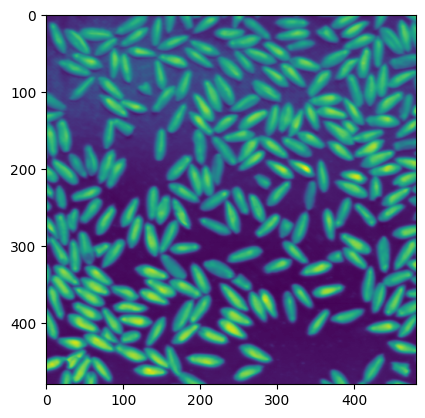

(480, 480, 24)


In [3]:
from preprocessing import preprocessFullHSI
import matplotlib.pyplot as plt

# Specify paths
hr_path = 'data/raw/FX10/spelt_s3.hdf5'
hr_mtx_path = 'data/raw/calibration/hrHSI_matrix.npy'
hr_dist_path = 'data/raw/calibration/hrHSI_dist.npy'

# Snapshot dimensions and wavelengths
# ss_shape = (210, 399, 24)
ss_shape = (210, 210, 24) # Square
ss_wavelengths = [667, 679, 691, 703, 715, 
                  727, 739, 751, 763, 775, 
                  787, 799, 811, 823, 835, 
                  847, 859, 871, 883, 895, 
                  907, 919, 931, 943]


# Set offsets and rotations
# hr_x_off = (106, 1018)   # Full: (0, 1084)
# hr_y_off = (189, 720)    # Full: (0, 1015)
hr_x_off = (110, 590)   # Square
hr_y_off = (191, 719)   # Square
rot = -0.3
shear = 0.02
# rot = -0.2
# shear = 0.017

# Load and preprocess file
hr_file = preprocessFullHSI(path_to_hdf5=hr_path, 
                            mtx_path=hr_mtx_path, 
                            dist_path=hr_dist_path, 
                            hr_x_off=hr_x_off, 
                            hr_y_off=hr_y_off, 
                            rot=rot, 
                            shear=shear, 
                            ss_shape=ss_shape, 
                            ss_wavelengths=ss_wavelengths)
hr_img = hr_file[0]
hr_wavelengths = hr_file[1]

# Display image
plt.imshow(hr_img[:, :, 3])
plt.show()

print(hr_img.shape)

### Load snapshot

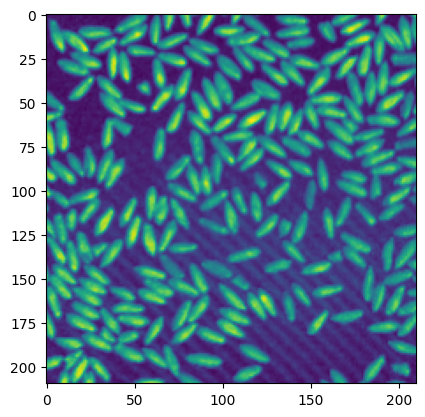

(210, 210, 24)


In [4]:
from preprocessing import preprocessSnapshot
import matplotlib.pyplot as plt

# Specify paths
ss_path = "data/raw/Snapshot/processed/train/spelt_s3/"
ss_mtx_path = 'data/raw/calibration/snapshot_matrix.npy'
ss_dist_path = 'data/raw/calibration/snapshot_dist.npy'

# Load and preprocess file
# ss_x_off = (3, 402)
# ss_y_off = (2, 212)
ss_x_off = (3, 213)
ss_y_off = (2, 212)

ss_file = preprocessSnapshot(ss_path, ss_mtx_path, ss_dist_path, ss_x_off, ss_y_off)

# Store to variables
ss_img = ss_file[0]
ss_wavelengths = ss_file[1]


plt.imshow(ss_img[:, :, 3])
plt.show()

print(ss_img.shape)

### Show side by side comparison

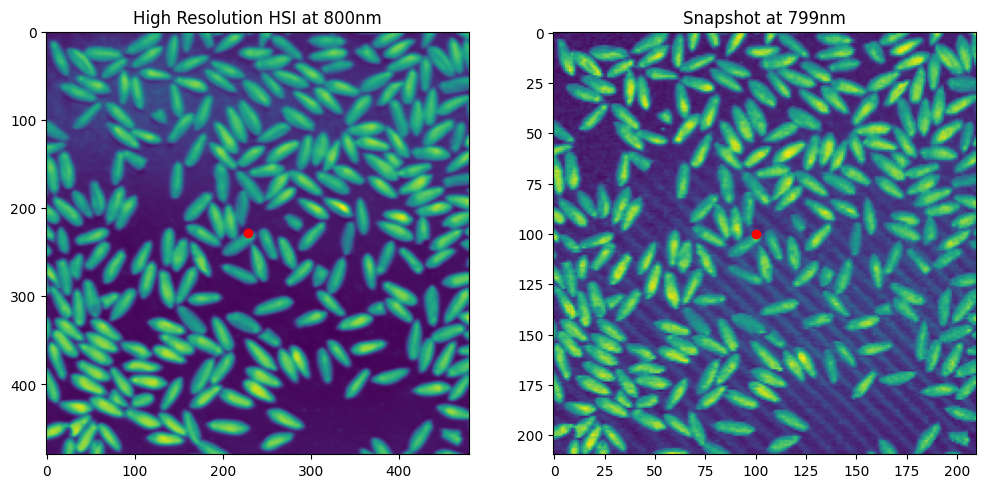

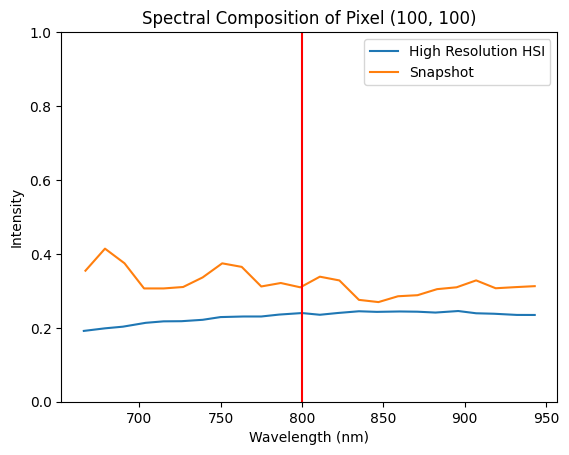

In [5]:
from align_images import plot_image_comparison

# Plot image comparison
plot_image_comparison(hr_img=hr_img, 
                      hr_wavelengths=hr_wavelengths, 
                      ss_img=ss_img, 
                      ss_wavelengths=ss_wavelengths, 
                      selected_pixel=(100, 100),
                      selected_spectrum=800)

In [6]:
print(ss_img.shape)
print(hr_img.shape)

# Print aspect ratio
print("HrHSI:", round(hr_img.shape[1] / hr_img.shape[0], 6))
print("Shapshot:", round(ss_img.shape[1] / ss_img.shape[0], 6))

(210, 210, 24)
(480, 480, 24)
HrHSI: 1.0
Shapshot: 1.0


# Compare fully-processed files

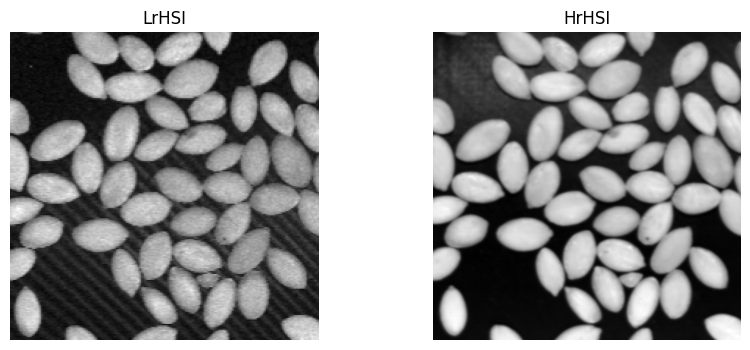

Train: 1.0
Val: 1.0
Train: (210, 210, 24)
Val: (480, 480, 24)


In [20]:
import numpy as np

# List of all grains
grains = ["spelt", "rye", "flax", "wheatgrass", "pumpkin", "sunflower", 
          "flaxb", "buckwheat", "millet", "barley", "mix", "corn"]

# Select image
image_id = "pumpkin_s2"

train_img = np.load("data/processed/full_hsi/lr/" + image_id + ".npy")
val_img = np.load("data/processed/full_hsi/hr/" + image_id + ".npy")


# Plot images next to each other
import matplotlib.pyplot as plt

# Plot
fig, axs = plt.subplots(1, 2, figsize=(10, 4))
# plt.tight_layout()
# fig.suptitle(image_id, fontsize=16)
axs[0].axis('off')
axs[1].axis('off')
axs[0].imshow(train_img[:, :, 10], cmap="gray")
axs[1].imshow(val_img[:, :, 10], cmap="gray")
axs[0].set_title("LrHSI")
axs[1].set_title("HrHSI")
plt.show()

# Print aspect ratios
print("Train:", round(train_img.shape[1] / train_img.shape[0], 6))
print("Val:", round(val_img.shape[1] / val_img.shape[0], 6))

# Print shapes
print("Train:", train_img.shape)
print("Val:", val_img.shape)

In [ ]:
# print(val_img)
print(train_img.shape)

In [ ]:
import cv2 as cv
import numpy as np
import os

def npy_to_rgb(input_folder, target_folder):

    # List all images in the folder
    inputs = os.listdir(input_folder)
    print(inputs)

    for file_name in inputs:
        # Read the image using OpenCV
        image = np.load(input_folder + file_name)
        
        # Select only 3 channels
        rgb_array = image[:, :, [0, 12, 23]] * 255

        # Save the npy file in target folder
        # np.save(target_folder + file_name.split('/')[-1][:-4] + ".npy", rgb_array)

        # Save the image as a jpg file
        cv.imwrite(target_folder + file_name.split('/')[-1][:-4] + ".jpg", rgb_array)


# Example usage
# input_folder = "data/processed/bicubic_480/"
input_folder = "data/processed/full_hsi/bi_240/"
# target_folder = "data/processed/rgb_array/bi_480/"
target_folder = "data/processed/rgb_array/bi_240_jpg/"
rgb_array = npy_to_rgb(input_folder, target_folder)

# Loop over all images to check for corruption

In [ ]:
import numpy as np
import cv2 as cv

# List of all grains
grains = ["spelt", "rye", "flax", "wheatgrass", "pumpkin", "sunflower", 
          "flaxb", "buckwheat", "millet", "barley", "mix", "corn"]
densities = ["s", "m", "l"]
img_nos = [0, 1, 2, 3, 4]


for f in grains:
    for d in densities:
        for i in img_nos:
            image_id = f + "_" + d + str(i)
            train_img = np.load("data/Processed/train/" + image_id + ".npy")
            val_img = np.load("data/Processed/val/" + image_id + ".npy")
            bicubic_img = np.load("data/Processed/bicubic_480/" + image_id + ".npy")
            cv.imwrite("data/Processed/images/train/" + image_id + ".jpg", train_img[:, :, 10] * 255)
            cv.imwrite("data/Processed/images/val/" + image_id + ".jpg", val_img[:, :, 10] * 255)
            cv.imwrite("data/Processed/images/bicubic_480/" + image_id + ".jpg", bicubic_img[:, :, 10] * 255)

In [ ]:
# Load processed training image
train_img = np.load("data/Processed/train/corn_m3.npy")
print("train: ", train_img.shape)

# Load processed validation image
val_img = np.load("data/Processed/val/barley_m3.npy")
print("val: ", val_img.shape)

# Load processed bicubic image
bicubic_img = np.load("data/Processed/bicubic/barley_m3.npy")
print("bicubic: ", bicubic_img.shape)

# .npy Image Viewer

interactive(children=(IntSlider(value=0, description='channel', max=23), Output()), _dom_classes=('widget-inte…

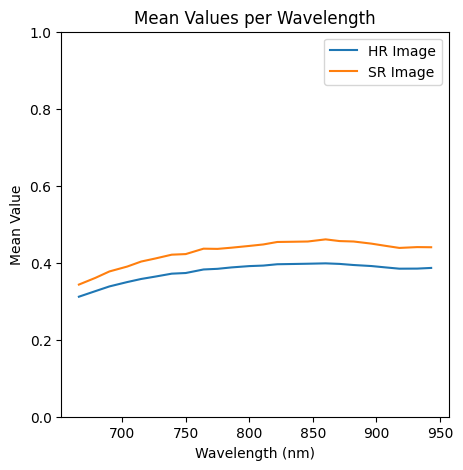

In [22]:
import numpy as np
from ipywidgets import interact, IntSlider
import matplotlib.pyplot as plt

hr_wavelengths = [666, 679, 690, 704, 715, 
                  726, 739, 750, 764, 775, 
                  786, 800, 811, 822, 835, 
                  846, 860, 871, 882, 896, 
                  907, 918, 932, 943]

def view_two_npy_images(channel=0):

    # Display the images
    fig, axs = plt.subplots(1, 3, figsize=(16, 6))
    fig.suptitle(f"img: {img_id}, \n model: {model}", fontsize=16)
    axs[0].imshow(hr_img[:, :, channel], vmin=0, vmax=1)
    axs[0].set_title(f'HR Image - Channel: {channel}')
    axs[0].axis('off')
    
    axs[1].imshow(sr_img[:, :, channel], vmin=0, vmax=1)
    axs[1].set_title(f'SR Image - Channel: {channel}')
    axs[1].axis('off')

    # Difference between images
    im = axs[2].imshow(difference_image[:, :, channel], cmap='bwr', vmin=-1, vmax=1)
    axs[2].set_title(f'Difference Image - Channel: {channel}')
    axs[2].axis('off')
    fig.colorbar(im, ax=axs[2], orientation='vertical', fraction=0.046, pad=0.04)



def plot_values_per_wavelengths(wavelengths):
    
    # Calculate mean values per wavelength
    mean_values_hr = hr_img.mean(axis=(0, 1))
    mean_values_sr = sr_img.mean(axis=(0, 1))
    
    # Plot the values
    plt.figure(figsize=(5, 5))
    plt.plot(wavelengths, mean_values_hr, label='HR Image')
    plt.plot(wavelengths, mean_values_sr, label='SR Image')
    plt.xlabel('Wavelength (nm)')
    plt.ylabel('Mean Value')
    plt.ylim(0, 1)
    plt.title('Mean Values per Wavelength')
    plt.legend()


img_id = "flaxb_s4"
model = "HSI_x2_val3_150000"
# model = "bicubic"

# Load images
hr_path = "results/c_hr/" + img_id + ".npy"
sr_path = "results/models/" + model + "/sr_synth/" + img_id + ".npy"

# hr_path = "data/processed/full_hsi_val/val/hr/pumpkin_l4.npy"
# sr_path = "Real-ESRGAN/experiments/finetune_HSIx2_val3_synth/visualization/pumpkin_l4/pumpkin_l4_5000.npy"

hr_img = np.load(hr_path)
sr_img = np.load(sr_path)
difference_image = hr_img - sr_img

# Show images
interact(view_two_npy_images, hr_path=hr_path, sr_path=sr_path, img_id=img_id, model=model, channel=IntSlider(min=0, max=23, step=1, value=0))

# Show mean values per wavelength
plot_values_per_wavelengths(hr_wavelengths)  


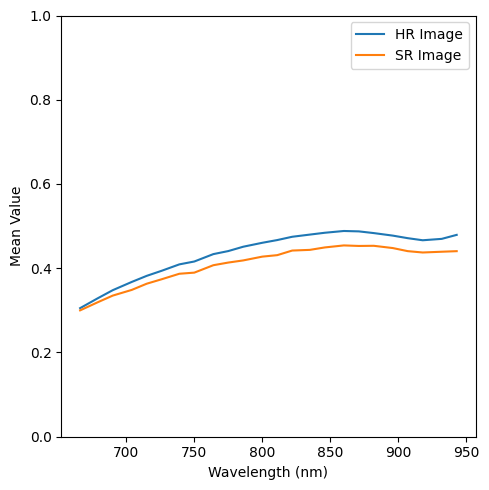

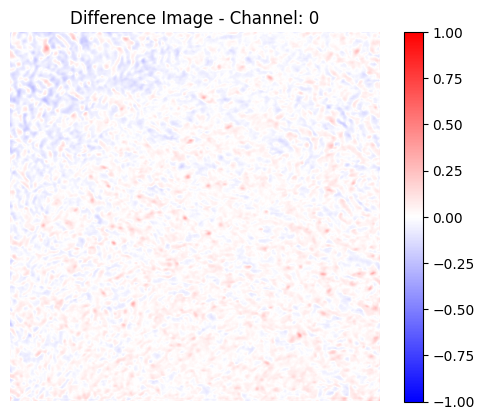

In [ ]:
import os

img_id = "flaxb_l4"
model = "HSI_x2_val3_150000"
channel = 0

# Load images
hr_path = "results/c_hr/" + img_id + ".npy"
sr_path = "results/models/" + model + "/sr/" + img_id + ".npy"

# Load the HR and SR images
hr_image = np.load(hr_path)
sr_image = np.load(sr_path)

# Compute the difference image
difference_image = hr_image - sr_image

wavelengths = [666, 679, 690, 704, 715, 
                  726, 739, 750, 764, 775, 
                  786, 800, 811, 822, 835, 
                  846, 860, 871, 882, 896, 
                  907, 918, 932, 943]


# Calculate mean values per wavelength
mean_values_hr = hr_image.mean(axis=(0, 1))
mean_values_sr = sr_image.mean(axis=(0, 1))
    
# Plot the values
plt.figure(figsize=(5, 5))
plt.plot(wavelengths, mean_values_hr, label='HR Image')
plt.plot(wavelengths, mean_values_sr, label='SR Image')
plt.xlabel('Wavelength (nm)')
plt.ylabel('Mean Value')
plt.ylim(0, 1)
plt.legend()
plt.tight_layout()
plt.show()
# Save this image


# Display the difference image for a specific channel
plt.imshow(difference_image[:, :, channel], cmap='bwr')
plt.colorbar()
plt.clim(-1, 1)
plt.title(f'Difference Image - Channel: {channel}')
plt.axis('off')
plt.show()

# Save image with colorbar


# plt.imsave(f"visualizations/{model}/{img_id}_ch{channel}_hr.png", hr_image[:, :, channel], cmap='gray', vmin=0, vmax=1)
# plt.imsave(f"visualizations/{model}/{img_id}_ch{channel}_sr.png", sr_image[:, :, channel], cmap='gray', vmin=0, vmax=1)
# plt.imsave(f"visualizations/{model}/{img_id}_ch{channel}_diff.png", difference_image[:, :, channel], cmap='bwr', vmin=-1, vmax=1)

# # Save image of wavelengths
# plt.savefig(f"visualizations/{model}/{img_id}_mean_values.png")

plt.imsave(f"visualizations/{img_id}_ch{channel}_hr.png", hr_image[:, :, channel], cmap='gray', vmin=0, vmax=1)

### Save grayscale images

In [ ]:
# Save grayscale images
import os

img_id = "flaxb_l4"
channel = 12

# Load images
hr_path = "data/processed/full_hsi_val/train/" + img_id + ".npy"
lr_path = "results/models/" + model + "/sr/" + img_id + ".npy"

# Load the HR and SR images
hr_image = np.load(hr_path)
sr_image = np.load(sr_path)

# Preview grayscale 

In [6]:
import cv2 as cv
import numpy as np

# Example usage
image_path = sr_path
# image_path = "Real-ESRGAN/inputs/barley_l4.npy"
# image_path = "Real-ESRGAN/inputs/pumpkin_l4.npy"
# image_path = "Real-ESRGAN/experiments/finetune_HSIx2_val/visualization/barley_l0/barley_l0_300.npy"
# image_path = "data/processed/full_hsi_val/val/bi_240/barley_m4.npy"
image = np.load(image_path)

print(image.shape)
print(type(image))

print(image.max())
print(image.min())

(240, 240, 24)
<class 'numpy.ndarray'>
1.0
0.0


In [ ]:
import numpy as np
import os
import random

# Load all .npy files in the folder
folder_path = "data/processed/full_hsi/hr/"
npy_file_list = [os.path.join(folder_path, file) for file in os.listdir(folder_path) if file.endswith('.npy')]


sum_values = None
count = 0

# Iterate through the random files and accumulate sum and count
for npy_file in npy_file_list:
	data = np.load(npy_file)
	if sum_values is None:
		sum_values = np.zeros(data.shape[-1])
	sum_values += np.sum(data, axis=(0, 1))
	count += data.shape[0] * data.shape[1]

# Calculate the mean and sd for each channel
mean_values = sum_values / count


# Initialize sum of squares
sum_squares = np.zeros(data.shape[-1])

# Iterate through the files again to calculate sum of squares
for npy_file in npy_file_list:
    data = np.load(npy_file)
    sum_squares += np.sum((data - mean_values) ** 2, axis=(0, 1))

# Calculate standard deviation
sd_values = np.sqrt(sum_squares / count)



print("Mean values for each channel:", np.round(mean_values, 3))
print("Standard deviation for each channel:", np.round(sd_values, 3))

In [175]:
# Bicubic upscaling of 240x240x24 npy arrays to 480x480x24
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os

images = os.listdir("Real-ESRGAN/inputs_synth/")

for image in images:
    # Load the image
    image_name = np.load(f"Real-ESRGAN/inputs_synth/{image}")

    # Upscale the image using bicubic interpolation
    upscaled_image = cv2.resize(image_name, (480, 480), interpolation=cv2.INTER_CUBIC)

    # Save the image
    np.save(f"results/models/bicubic/sr_synth/{image}", upscaled_image)

# # Save the image
# np.save("results/models/bicubic/sr_synth/barley_s4.npy", upscaled_image)

